**Цель задания**: научиться базово подбирать архитектуру, строить и обучать свёрточные нейронные сети для решения задачи классификации.

**Контекст**
Это домашнее задание по сути является продолжением предыдущего. В нём вы меняете архитектуру сети с полносвязной на свёрточную.

**Задание**
Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

**Инструкция к выполнению задания**

Скачайте тренировочную и тестовою часть датасета Fashion MNIST
Постройте архитектуру модели, используя свёрточные слои, слои регуляризации и один финальный полносвязный слой
Обучите модель до необходимого качества. Если сеть не обучается до необходимого качества, попробуйте поменять архитектуру сети, варьируя параметры свёрток, количество каналов, количество свёрточных слоёв, слои регуляризации, тип оптимайзера и т. д.

In [ ]:
import torchvision as tv
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
f_mnist_train = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
f_mnist_test  = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16038341.74it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 279120.31it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4965706.86it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16583930.10it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
BATCH_SIZE=256
train, test = torch.utils.data.DataLoader(f_mnist_train, shuffle=True, batch_size=BATCH_SIZE), torch.utils.data.DataLoader(f_mnist_test, shuffle=True, batch_size=BATCH_SIZE)

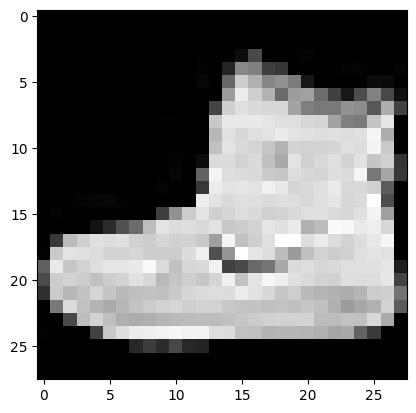

In [ ]:
plt.imshow(f_mnist_train[0][0].numpy().reshape(28,28), cmap='gray')

In [ ]:
for X, y in train:
    print(X.shape, y.shape)
    break

for X, y in test:
    print(X.shape, y.shape)
    break

torch.Size([256, 1, 28, 28]) torch.Size([256])
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [ ]:
LR = 0.01

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 12, kernel_size=4, padding=1),
    torch.nn.BatchNorm2d(12),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d(2, stride=2),
    torch.nn.Conv2d(12, 24, kernel_size=4),
    torch.nn.BatchNorm2d(24),
    torch.nn.ReLU(),
    #torch.nn.MaxPool2d(2, stride=2),
    #torch.nn.Dropout(0.25),
    torch.nn.Conv2d(24, 6, kernel_size=2),
    torch.nn.BatchNorm2d(6),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(726, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10)
)


loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.Adam(model.parameters(), LR)

In [ ]:
X = f_mnist_train[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 12, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 12, 27, 27])
Layer BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 12, 27, 27])
Layer ReLU(). X shape: torch.Size([1, 12, 27, 27])
Layer Conv2d(12, 24, kernel_size=(4, 4), stride=(1, 1)). X shape: torch.Size([1, 24, 24, 24])
Layer BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 24, 24, 24])
Layer ReLU(). X shape: torch.Size([1, 24, 24, 24])
Layer Conv2d(24, 6, kernel_size=(2, 2), stride=(1, 1)). X shape: torch.Size([1, 6, 23, 23])
Layer BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 6, 23, 23])
Layer ReLU(). X shape: torch.Size([1, 6, 23, 23])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 11, 11])
Layer Flatten(start_dim=1, end_dim=-1)

In [ ]:
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):

    start=time.time()
    train_loss, train_acc, train_n = 0., 0., 0
    test_loss, test_acc, test_n = 0., 0., 0
    

    model.train()
    for X, y in train:
        trainer.zero_grad()
        y_pred = model(X)
        l = loss(y_pred, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item()
        train_n += len(X)
    
    model.eval()
    for X, y in test:
        y_pred = model(X)
        l = loss(y_pred, y)
        test_loss += l.item()
        test_acc += (y_pred.argmax(dim=1) == y).sum().item()
        test_n += len(X)
        
    print("\nepoch: {}, taked: {:.2f}, train_loss: {:.3f}, train_acc: {:.2f}%, test_loss: {:.3f}, test_acc: {:.2f}%".format(
        epoch, time.time() - start, train_loss / train_n, train_acc / train_n *100 , test_loss / test_n, test_acc / test_n *100))


epoch: 1, taked: 81.45, train_loss: 0.569, train_acc: 78.23%, test_loss: 0.396, test_acc: 85.61%

epoch: 2, taked: 70.37, train_loss: 0.320, train_acc: 88.35%, test_loss: 0.351, test_acc: 87.10%

epoch: 3, taked: 70.98, train_loss: 0.272, train_acc: 90.00%, test_loss: 0.296, test_acc: 89.56%

epoch: 4, taked: 72.21, train_loss: 0.243, train_acc: 91.00%, test_loss: 0.283, test_acc: 90.02%

epoch: 5, taked: 70.92, train_loss: 0.224, train_acc: 91.68%, test_loss: 0.276, test_acc: 90.06%

epoch: 6, taked: 72.02, train_loss: 0.211, train_acc: 92.32%, test_loss: 0.272, test_acc: 90.71%

epoch: 7, taked: 72.33, train_loss: 0.193, train_acc: 92.92%, test_loss: 0.288, test_acc: 89.74%

epoch: 8, taked: 71.66, train_loss: 0.186, train_acc: 93.19%, test_loss: 0.290, test_acc: 89.96%

epoch: 9, taked: 70.95, train_loss: 0.170, train_acc: 93.74%, test_loss: 0.278, test_acc: 90.97%

epoch: 10, taked: 71.64, train_loss: 0.165, train_acc: 93.91%, test_loss: 0.279, test_acc: 90.71%
